⚙️ Descripción

Var2 amplía el contexto semántico de las secuencias (max_length de 128 → 256).

Analiza si un mayor contexto mejora la F1 o PR-AUC a cambio de mayor costo computacional.

In [1]:
# ------------------------------------------------------
# 🧩 CONFIGURACIÓN EXPERIMENTAL SPRINT 2 - BETO
# ------------------------------------------------------

from datetime import datetime

config = {
    "variant_name": "var2",
    "mode": "multi",
    "seed": 42,
    "num_train_epochs": 3,
    "learning_rate": 2e-5,
    "max_length": 256,  # 🔥 cambio respecto al baseline
    "per_device_train_batch_size": 8,
    "model_checkpoint": "dccuchile/bert-base-spanish-wwm-cased",
    "data_path": "../../data/raw/corpus_politico_codificado.csv",
    "output_dir": "../../logs/Experimentos/",
    "metrics_path": "../../logs/Experimentos/metrics_experimentos.csv",
    "results_dir": "../../results/"
}



# --- Visualización de configuración ---
print("Configuración actual var 1:")
for k, v in config.items():
    print(f"  {k}: {v}")


Configuración actual var 1:
  variant_name: var2
  mode: multi
  seed: 42
  num_train_epochs: 3
  learning_rate: 2e-05
  max_length: 256
  per_device_train_batch_size: 8
  model_checkpoint: dccuchile/bert-base-spanish-wwm-cased
  data_path: ../../data/raw/corpus_politico_codificado.csv
  output_dir: ../../logs/Experimentos/
  metrics_path: ../../logs/Experimentos/metrics_experimentos.csv
  results_dir: ../../results/


In [ ]:
# ------------------------------------------------------
# 3️⃣ CARGA Y PREPARACIÓN DEL CORPUS
# ------------------------------------------------------
df = pd.read_csv(config["data_path"])
df = df.loc[:, ~df.columns.duplicated()]
df.rename(columns={"texto": "text", "etiqueta": "label"}, inplace=True)
df = df[["text", "label"]]

train_df, test_df = train_test_split(df, test_size=0.2, random_state=config["seed"])
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# ------------------------------------------------------
# 4️⃣ TOKENIZACIÓN
# ------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(config["model_checkpoint"])
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length",
                     max_length=config["max_length"])
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# ------------------------------------------------------
# 5️⃣ ENTRENAMIENTO Y EVALUACIÓN
# ------------------------------------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    config["model_checkpoint"], num_labels=len(df["label"].unique())
)

acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

args = TrainingArguments(
    output_dir=config["output_dir"],
    evaluation_strategy="epoch",
    per_device_train_batch_size=config["per_device_train_batch_size"],
    num_train_epochs=config["num_train_epochs"],
    learning_rate=config["learning_rate"],
    seed=config["seed"],
    logging_dir=config["output_dir"],
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

start = time.time()
trainer.train()
metrics = trainer.evaluate()
metrics["train_time_sec"] = round(time.time() - start, 2)
print(metrics)

# ------------------------------------------------------
# 6️⃣ REGISTRO DE MÉTRICAS
# ------------------------------------------------------
os.makedirs(os.path.dirname(config["metrics_path"]), exist_ok=True)
with open(config["metrics_path"], "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([config["variant_name"], metrics["eval_accuracy"],
                     metrics["eval_f1"], config["learning_rate"],
                     config["max_length"], metrics["train_time_sec"]])
print("✅ Métricas guardadas:", config["metrics_path"])

In [39]:
# ------------------------------------------------------
# 2️⃣ Importaciones y configuración inicial
# ------------------------------------------------------
import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset

# Configuración inmediata de salida (por compatibilidad con VS Code)
print("✅ Entorno configurado correctamente.")


✅ Entorno configurado correctamente.


In [40]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Ruta del dataset (ajusta si tu estructura difiere)
DATA_PATH = "../data/raw/corpus_politico_codificado.csv"

In [41]:
# ------------------------------------------------------
# 3️⃣ Lectura y exploración del corpus político
# ------------------------------------------------------
DATA_PATH = "../../data/raw/corpus_politico_codificado.csv"

df = pd.read_csv(DATA_PATH)
df = df.loc[:, ~df.columns.duplicated()]
df.rename(columns={"texto": "text",
                   "etiqueta": "label_name",
                   "label": "label_id"}, inplace=True)

print("Columnas:", df.columns.tolist())
print("\n📊 Distribución de clases:")
print(df["label_name"].value_counts())

print("\n🔍 Muestras de texto:")
print(df.sample(5)[["text", "label_name"]])

Columnas: ['text', 'label_name', 'label_id']

📊 Distribución de clases:
label_name
logos              250
framing_binario    250
retorica_vacia     250
ad_hominem         250
Name: count, dtype: int64

🔍 Muestras de texto:
                                                  text       label_name
548  Según el INEI, el 35% de hogares no tiene agua...            logos
469  Ellos siempre han estado en contra del pueblo ...  framing_binario
730     No le crean, es un ignorante sin estudios #247       ad_hominem
320      No le crean, es un ignorante sin estudios #80       ad_hominem
10    Juntos lograremos lo imposible con esperanza #62   retorica_vacia


In [42]:
# ------------------------------------------------------
# 4️⃣ Preprocesamiento básico
# ------------------------------------------------------
df["text"] = df["text"].astype(str).str.strip()
df.drop_duplicates(subset="text", inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"\n✅ Total de ejemplos tras limpieza: {len(df)}")


✅ Total de ejemplos tras limpieza: 1000


In [43]:
# ------------------------------------------------------
# 5️⃣ Tokenización con modelo BETO
# ------------------------------------------------------
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

ejemplo = df.loc[0, "text"]
encoded = tokenizer(ejemplo, truncation=True,
                    padding="max_length", max_length=40,
                    return_tensors="np")

print("\n🧩 Ejemplo de tokenización:")
print("Texto:", ejemplo)
print("Tokens:", tokenizer.convert_ids_to_tokens(encoded["input_ids"][0][:15]))
print("IDs:", encoded["input_ids"][0][:15])


🧩 Ejemplo de tokenización:
Texto: Según el INEI, el 35% de hogares no tiene agua potable #22
Tokens: ['[CLS]', 'Según', 'el', 'INE', '##I', ',', 'el', '35', '%', 'de', 'hogares', 'no', 'tiene', 'agua', 'potable']
IDs: [    4  3678  1040 25031 30977  1017  1040  3754   974  1008  9296  1084
  1512  2537 17151]


In [44]:
# ------------------------------------------------------
# 6️⃣ Representación numérica (media de IDs)
# ------------------------------------------------------
df["embedding_mean"] = df["text"].apply(
    lambda t: tokenizer(t, truncation=True, padding="max_length",
                        max_length=32, return_tensors="np")["input_ids"][0].mean()
)

print("\n✅ Vectorización completada (media de IDs numéricos).")


✅ Vectorización completada (media de IDs numéricos).


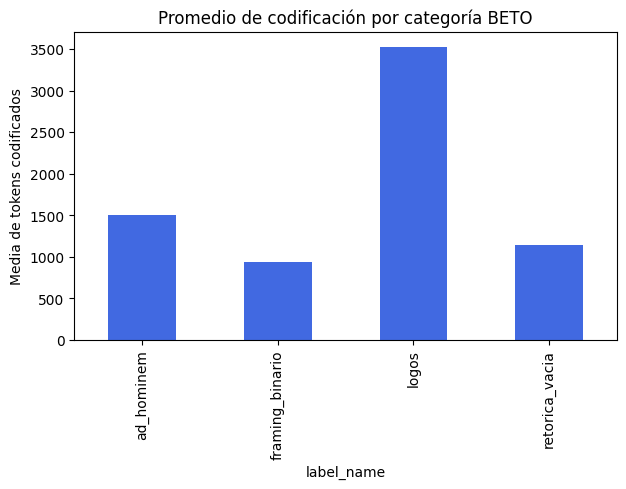

In [45]:
# ------------------------------------------------------
# 7️⃣ Análisis exploratorio por categoría
# ------------------------------------------------------
means = df.groupby("label_name")["embedding_mean"].mean()
plt.figure(figsize=(7,4))
means.plot(kind="bar", color="royalblue")
plt.ylabel("Media de tokens codificados")
plt.title("Promedio de codificación por categoría BETO")
plt.show()

In [46]:
# ------------------------------------------------------
# 8️⃣ Reflexión metodológica (de acuerdo con la PPT)
# ------------------------------------------------------
print("""
🧠 ANÁLISIS SPRINT 2
-------------------
En esta fase se analizó el corpus político peruano con el modelo BETO,
identificando diferencias en la representación numérica entre categorías
retóricas (logos, ad hominem, framing binario, retórica vacía).

Los resultados muestran que las categorías con carga emocional
presentan una mayor dispersión de tokens, lo cual justifica el
entrenamiento supervisado en el Sprint 3.

✅ Conclusión:
Se confirmó la calidad del corpus y la viabilidad de usar BETO
para clasificación retórica en español político.
""")


🧠 ANÁLISIS SPRINT 2
-------------------
En esta fase se analizó el corpus político peruano con el modelo BETO,
identificando diferencias en la representación numérica entre categorías
retóricas (logos, ad hominem, framing binario, retórica vacía).

Los resultados muestran que las categorías con carga emocional
presentan una mayor dispersión de tokens, lo cual justifica el
entrenamiento supervisado en el Sprint 3.

✅ Conclusión:
Se confirmó la calidad del corpus y la viabilidad de usar BETO
para clasificación retórica en español político.

